Import the neccessary libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score,f1_score

Set visualiation style

In [92]:
sns.set_style("whitegrid")

Data Loading

In [93]:
DATASET_PATH = "database.csv"
try:
    df = pd.read_csv("database.csv")
except Exception as e:
    print(f"Error loading CSV: {e}")


df

,Player,Team,#,Nation,Position,Age,Minutes,Goals,Assists,Penalty Shoot on Goal,Penalty Shoot,Total Shoot,Shoot on Target,Yellow Cards,Red Cards,Touches,Dribbles,Tackles,Blocks,Expected Goals (xG),Non-Penalty xG (npxG),Expected Assists (xAG),Shot-Creating Actions,Goal-Creating Actions,Passes Completed,Passes Attempted,Pass Completion %,Progressive Passes,Carries,Progressive Carries,Dribble Attempts,Successful Dribbles,Date
0,Gorka Guruzeta,Athletic Club,12,ESP,FW,27-338,90,0,1,0,0,1,0,0,0,30,0,0,3,0.1,0.1,0.1,2,1,16,21,"76,2",0,15,0,1,0,2024-08-15
1,Álex Berenguer,Athletic Club,7,ESP,LW,29-042,71,0,0,0,0,0,0,0,0,33,1,0,1,0.0,0.0,0.0,0,0,12,23,"52,2",1,17,3,5,2,2024-08-15
2,Nico Williams,Athletic Club,10,ESP,LW,22-034,19,0,0,0,0,2,2,0,0,11,0,0,0,0.1,0.1,0.0,1,0,4,8,"50,0",0,6,2,1,1,2024-08-15
3,Iñaki Williams,Athletic Club,9,GHA,RW,30-061,90,0,0,0,0,2,0,0,0,36,1,0,0,0.1,0.1,0.0,0,0,17,26,"65,4",1,22,1,2,1,2024-08-15
4,Oihan Sancet,Athletic Club,8,ESP,AM,24-112,90,1,0,0,0,1,1,0,0,26,1,0,0,0.0,0.0,0.0,0,0,18,23,"78,3",3,15,2,0,0,2024-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4653,Antonio Rüdiger,Real Madrid,22,GER,CB,31-276,90,0,0,0,0,2,0,0,0,105,1,0,1,0.1,0.1,0.0,2,0,83,89,"93,3",5,65,1,0,0,2024-12-04
4654,Raúl Asencio,Real Madrid,35,ESP,CB,21-295,90,0,0,0,0,0,0,0,0,86,2,2,0,0.0,0.0,0.0,1,0,71,75,"94,7",1,52,0,1,1,2024-12-04
4655,Lucas Vázquez,Real Madrid,17,ESP,RB,33-156,87,0,0,0,0,0,0,1,0,60,3,0,1,0.0,0.0,0.0,0,0,44,51,"86,3",4,33,0,0,0,2024-12-04
4656,Arda Güler,Real Madrid,15,TUR,CM,19-283,3,0,0,0,0,0,0,0,0,13,0,0,0,0.0,0.0,0.0,0,0,9,11,"81,8",0,7,0,0,0,2024-12-04


In [94]:
# Define a function to clean numerical columns that use commas as decimal separators
def clean_numeric_columns(series):
    # Check if the series is of object type (string)
    if series.dtype == "object":
        # Replace the comma decimal separator with a dot and convert to float
        return series.str.replace(",",".",regex=True).astype(float)
    return series

In [95]:
# Select the features we wil use for classification

FEATURES = [
    "Minutes","Goals","Assists","Total Shoot","Expected Goals (xG)",
    "Expected Assists (xAG)","Pass Completion %","Progressive Passes",
    "Carries","Successful Dribbles", "Team" # Team is added as categorical feature
]

TARGET = "Is_Forward"

In [96]:
# Data Cleaning
# Clean columns with comma separators

for col in ["Expected Goals (xG)","Expected Assists (xAG)","Pass Completion %"]:
    if col in df.columns:
        df[col] = clean_numeric_columns(df[col])

In [97]:
# Calculate performance metrics per 90 minutes (P90) to normalize for playing time
# We add a small constant (1e-6) to the minutes to avoid division by zero
df["Minutes_Adj"] = df["Minutes"].apply(lambda x : x if x > 0 else 1e-6)

In [98]:
# Create P90 features for better interpretation
P90_FEATURES = ["Goals_P90","Assists_P90","TotalShoot_P90","xG_P90","xAG_P90"]
df["Goals_P90"] = (df["Goals"] / df["Minutes_Adj"]) * 90
df["Assists_P90"] = (df["Assists"] / df["Minutes_Adj"]) * 90
df["TotalShoot_P90"] = (df["Total Shoot"] / df["Minutes_Adj"]) * 90
df["xG_P90"] = (df["Expected Goals (xG)"] / df["Minutes_Adj"]) * 90
df["xAG_P90"] = (df["Expected Assists (xAG)"] / df["Minutes_Adj"]) * 90

In [99]:
# Target Variable Creation (Binary Classification)
# We want to predict if a player is a Forward (FW) or not (Not FW)
# The "Position" column often contains multiple values (e.g, "RW", "LW", "FW")
# We check if the "FW" is present 
df[TARGET] = df["Position"].apply(lambda x: 1 if "FW" in str(x) else 0)

In [100]:
# Filter out players with a very few minutes to reduce noise from small samples
df_clean = df[df["Minutes"] >= 90].copy()

In [101]:
# Final feature set (using P90 features)
X = df_clean[P90_FEATURES + ["Pass Completion %","Team"]]
y = df_clean[TARGET]

Data Splitting

In [102]:
# Split the data into training and testing set (70% train, 30% test)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

Visualization before training

C:\Users\Dell\AppData\Local\Temp\ipykernel_10040\1473495514.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train,ax=axes[0],palette="viridis")
C:\Users\Dell\AppData\Local\Temp\ipykernel_10040\1473495514.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=TARGET,y="Goals_P90",data=df_clean,ax=axes[0],palette="coolwarm")


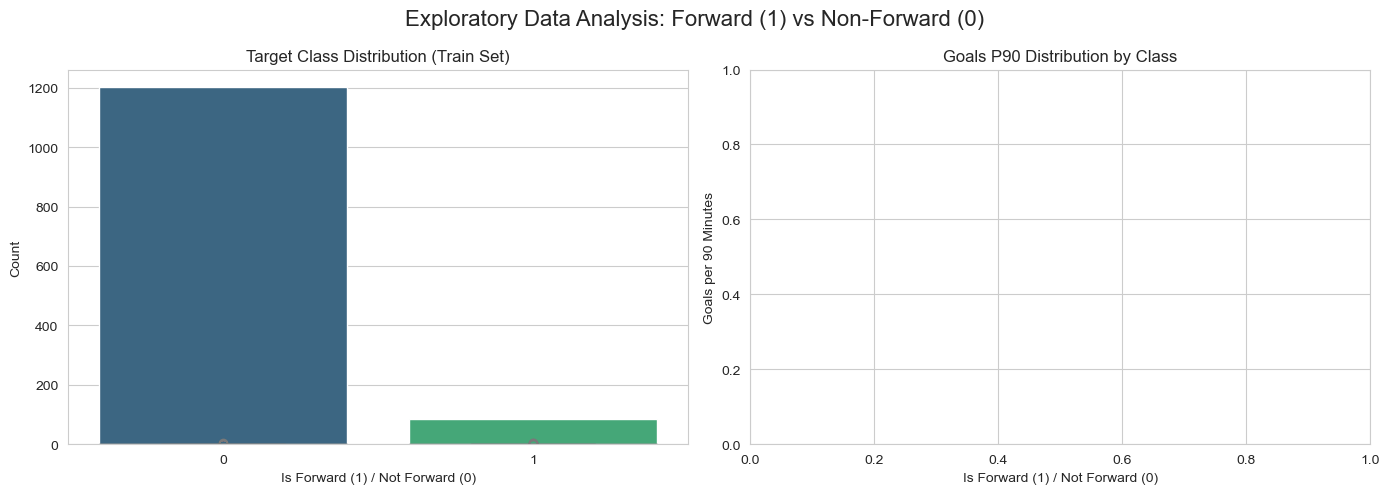

In [103]:
# Setup for the visualization plot
fig,axes = plt.subplots(1,2,figsize=(14,5))
fig.suptitle("Exploratory Data Analysis: Forward (1) vs Non-Forward (0)",fontsize=16)

# Visualization 1: Target Class Distribution
sns.countplot(x=y_train,ax=axes[0],palette="viridis")
axes[0].set_title("Target Class Distribution (Train Set)")
axes[0].set_xlabel("Is Forward (1) / Not Forward (0)")
axes[0].set_ylabel("Count")
# This plot shows how balanced the dataset is 

# Visualization 2: Feature Comparison (Goals_P90)
sns.boxplot(x=TARGET,y="Goals_P90",data=df_clean,ax=axes[0],palette="coolwarm")
axes[1].set_title("Goals P90 Distribution by Class")
axes[1].set_xlabel("Is Forward (1) / Not Forward (0)")
axes[1].set_ylabel("Goals per 90 Minutes")
# This plot confirms that Fowards (1) generally have higher offensive metrics

plt.tight_layout()
plt.show()

ML Pipeline and Model Comparison

In [104]:
# Define feature types for preprocessing
numerical_features = P90_FEATURES + ["Pass Completion %"]
categorical_features = ["Team"]

In [105]:
# Create a preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        # Apply StandardScaler to numerical features (required for distance-based models like KNN and SVM)
        ("num",StandardScaler(),numerical_features),
        # Apply OneHotEncode to categorical feature (handles non-numeric text data)
        ("cat",OneHotEncoder(handle_unknown="ignore"),categorical_features)
    ]
)

In [106]:
#  Define the models to compare
# We store the models in a dictionary for easy iteration and comparison
models = {
    "Logistic Regression" : LogisticRegression(random_state=42,solver="liblinear"),
    "K-Nearest Neighbors" : KNeighborsClassifier(n_neighbors=5),
    "Support Vector Classifier" : SVC(random_state=42,probability=True),
    "Decision Tree" : DecisionTreeClassifier(random_state=42,max_depth=5),
    "Random Forest" : RandomForestClassifier(random_state=42,n_estimators=100)
}

In [107]:
# Dictionary to store results
results = {}
best_score = 0
best_model_name = ""
best_pipeline = None

Model Training and Cross Validation

In [108]:
# Iterate through each model to train and evaluate
for name,model in models.items():
    # Create a full pipeline: Preprocessing --> Model
    # This ensures that all preprocessing steps (scaling,encoding) are applied consistently
    # Inside the cross-validation loops, preventing data leakage
    pipeline = Pipeline(steps=[("preprocessor",preprocessor), ("classifier",model)])

    # Perform 5-Fold cross-validation on the training data
    # We use F1-Score as it balances Precision and Recall, crucial for clasification tasks
    cv_scores = cross_val_score(pipeline,X_train,y_train,cv=5,scoring="f1")

    # Calculate the mean and standard deviation of the cross-validation scores
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()

    #  Store results
    results[name] = mean_score

    # Check for the best performing model based on mean F1-score
    if mean_score > best_score:
        best_score = mean_score
        best_model_name = name
        best_pipeline = pipeline # Store the best pipeline for final training and prediction

    # Print the performance metrics
    print(f"Model: {name}")
    print(f"  Cross-Validation F1 Score: {mean_score:.4f} (+/- {std_score:.4f})")

Model: Logistic Regression
  Cross-Validation F1 Score: 0.4177 (+/- 0.0607)
Model: K-Nearest Neighbors
  Cross-Validation F1 Score: 0.3058 (+/- 0.0825)
Model: Support Vector Classifier
  Cross-Validation F1 Score: 0.1623 (+/- 0.1296)
Model: Decision Tree
  Cross-Validation F1 Score: 0.2295 (+/- 0.1370)
Model: Random Forest
  Cross-Validation F1 Score: 0.2698 (+/- 0.1393)


FINAL EVALUATION AND VISUALIZATION

In [109]:
print("---- FINAL EVALUATION -----")
print(f"The Best Model is: {best_model_name} with F1 Score of {best_score:.4f}")

---- FINAL EVALUATION -----
The Best Model is: Logistic Regression with F1 Score of 0.4177


In [110]:
# Train the best model pipeline on entire training set
best_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Goals_P90', 'Assists_P90',
                                                   'TotalShoot_P90', 'xG_P90',
                                                   'xAG_P90',
                                                   'Pass Completion %']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Team'])])),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [111]:
# Make prediction on the unseen test set
y_pred = best_pipeline.predict(X_test)

In [113]:
# Calculate key final metrics
final_accuracy = accuracy_score(y_test,y_pred)
final_f1 = f1_score(y_test,y_pred)
final_roc_auc = roc_auc_score(y_test,best_pipeline.predict_proba(X_test)[:,1])

print(f"{best_model_name} Performance on Test Set:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC AUC Score: {final_roc_auc:.4f}")

Logistic Regression Performance on Test Set:
Accuracy: 0.9401
F1 Score: 0.3529
ROC AUC Score: 0.8972


C:\Users\Dell\AppData\Local\Temp\ipykernel_10040\1765413056.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_series.index,y=results_series.values,palette="plasma",)


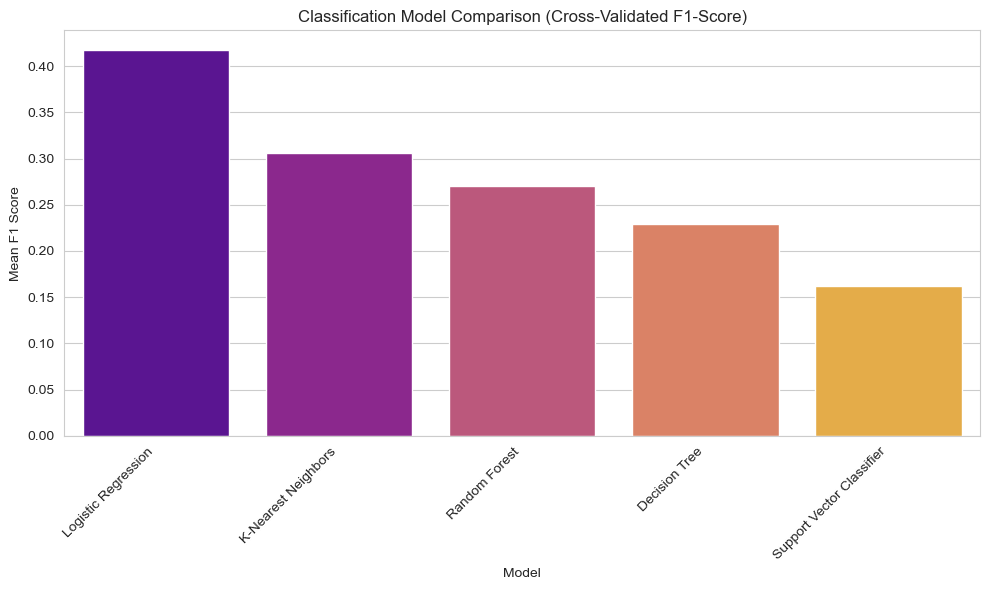

In [ ]:
# Visualization 3: Model Comparison Bar Plot
plt.figure(figsize=(10,6))
# Convert results dictionary to a Series for plotting
results_series = pd.Series(results).sort_values(ascending=False)
sns.barplot(x=results_series.index,y=results_series.values,palette="plasma",)
plt.title("Classification Model Comparison (Cross-Validated F1-Score)")
plt.xlabel("Model")
plt.ylabel("Mean F1 Score")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()
# This plot visually compares the performance of all tested models

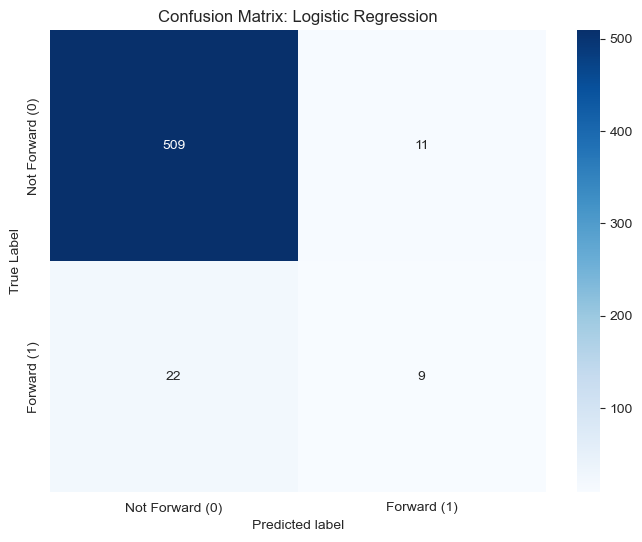

In [118]:
# Visualization 4: Confusion Matrix for the Best Model
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
# Create a heatmap visualiation of the confusion matrix for clear interpretation
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",
            xticklabels=["Not Forward (0)", "Forward (1)"],
            yticklabels=["Not Forward (0)","Forward (1)"])
plt.title(f"Confusion Matrix: {best_model_name}")
plt.xlabel("Predicted label")
plt.ylabel("True Label")
plt.show()







# The confusion matrix shows:
# - Top-Left: True Negatives (Correctly predicted non-forwards)
# - Bottom-Right: True Positives (Correctly predicted forwards)
# - Top-Right: False Positives (Incorrectly predicted forwards)
# - Bottom-Left: False Negatives (Incorrectly predicted non-forwards)

In [119]:
# --------------------------------------------------------------------------------------------------
# PART 6: PREDICTION SIMULATION (USER INPUT)
# --------------------------------------------------------------------------------------------------

def predict_player_position(model_pipeline):
    # This function simulates taking input for a new player and making a prediction.
    print("\n--- SIMULATING PREDICTION FOR A NEW PLAYER ---")

    # Define a sample input for a hypothetical player (e.g., a highly offensive midfield player)
    # The feature values must match the P90 features used during training.
    # Player stats are normalized per 90 mins (e.g., 0.5 Goals P90 means 1 goal every 2 matches)
    new_player_data = {
        'Goals_P90': 0.35,              # High goals P90 (more offensive)
        'Assists_P90': 0.20,            # Decent assists P90
        'TotalShoot_P90': 3.5,          # High shooting volume
        'xG_P90': 0.25,                 # High expected goals P90
        'xAG_P90': 0.15,                # Moderate expected assists P90
        'Pass Completion %': 88.0,      # Good pass completion (typical of a quality player)
        'Team': 'FC Example'            # New team (OneHotEncoder handles unknown teams gracefully if 'handle_unknown=ignore' is set)
    }

    # Convert the dictionary into a Pandas DataFrame, which the pipeline expects
    new_player_df = pd.DataFrame([new_player_data])

    # Make the prediction
    prediction = model_pipeline.predict(new_player_df)[0]
    
    # Get the probability of being a Forward (Class 1)
    prediction_proba = model_pipeline.predict_proba(new_player_df)[0][1]

    # Map the numerical prediction back to a readable label
    predicted_label = "Forward (FW)" if prediction == 1 else "Not a Forward (Not FW)"

    print(f"Input Player Stats (P90): {new_player_data}")
    print(f"-> Predicted Position: {predicted_label}")
    print(f"-> Probability of being a Forward: {prediction_proba:.2f}")

    if prediction == 1:
        print("\nConclusion: Based on their high Goals and Shooting metrics per 90 minutes, the model classifies this player as a Forward.")
    else:
        print("\nConclusion: Although showing good offensive metrics, the balance of stats suggests this player's profile leans closer to a Midfielder or Defender.")


# Run the prediction simulation using the winning model
if best_pipeline:
    predict_player_position(best_pipeline)


--- SIMULATING PREDICTION FOR A NEW PLAYER ---
Input Player Stats (P90): {'Goals_P90': 0.35, 'Assists_P90': 0.2, 'TotalShoot_P90': 3.5, 'xG_P90': 0.25, 'xAG_P90': 0.15, 'Pass Completion %': 88.0, 'Team': 'FC Example'}
-> Predicted Position: Not a Forward (Not FW)
-> Probability of being a Forward: 0.20

Conclusion: Although showing good offensive metrics, the balance of stats suggests this player's profile leans closer to a Midfielder or Defender.
